**Project Description:** Датасет содержит сведения о 40 000 ресторанах Европы по данным сайта TripAdvisor.

**Goal:**

**Objectives:** Создать модель для предсказания рейтинга ресторанов 'Rating'.

**Dataset Description:** Датасет содержит следующие признаки (переменные):
1. Restaurant_id — идентификационный номер ресторана / сети ресторанов;
2. City — город, в котором находится ресторан;
3. Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
4. Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
5. Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
6. Price Range — диапазон цен в ресторане;
7. Number of Reviews — количество отзывов о ресторане;
8. Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
9. URL_TA — URL страницы ресторана на TripAdvosor;
10. ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [371]:
import math
from collections import Counter
from itertools import chain, combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy.stats import ttest_ind

#pd.options.display.max_columns = 40

## Подготовка данных
### Сбор и форматирование данных
**Чтение датасета**

In [372]:
def dollar_replace(s):
    s = s.replace('$$$$$', '5')
    s = s.replace('$$$$', '4')
    s = s.replace('$$$', '3')
    s = s.replace('$$', '2')
    s = s.replace('$', '1')
    s = s.replace('2 - 3', '2.5')
    if s == '':
        return np.nan
    return float(s)

In [373]:
data = pd.read_csv('main_task.xls', converters={'Price Range': dollar_replace})

**Проверяем названия переменных датасета и переименовываем при необходимости**

In [374]:
data.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews', 'URL_TA', 'ID_TA'],
      dtype='object')

In [375]:
data.rename(columns={
    'Cuisine Style': 'Cuisine',
    'Restaurant_id': 'Restr_id',
    'Price Range': 'Price_range',
    'Number of Reviews': 'Reviews_num',
}, inplace=True)

**Проверяем формат переменных**

In [376]:
cols_re = {
    'Restr_id': 'id_\d+',
    'ID_TA': 'd\d+',
}

for key, val in cols_re.items():
    a = data[key].str.match(val).sum()
    b = data[key].notna().sum()
    print(f"'{key}' соответствует формату '{val}' для {a} из {b} строк")

'Restr_id' соответствует формату 'id_\d+' для 40000 из 40000 строк
'ID_TA' соответствует формату 'd\d+' для 40000 из 40000 строк


In [377]:
data['Cuisine'] = data['Cuisine'].str.strip('[]').str.replace("',\s'", '|').str.replace("'", '')

**Удаляем дубликаты строк**

In [378]:
data.drop_duplicates('ID_TA', inplace=True)

### Feature engineering

In [379]:
# Split features from 'Reviews'
data['Reviews'] = data['Reviews'].str.lower().replace('[[], []]', np.nan, regex=False)
data[['Reviews', 'Reviews_date']] = data['Reviews'].str.strip('[]').str.split('],\s\[', expand=True)
data[['Review1', 'Review2']] = data['Reviews'].str.strip("'\"").str.split("['\"],\s['\"]", expand=True)
data['Review1'] = data['Review1'].str.replace('[().,!?@#$%^&*:;]', ' ').str.replace("['\"]", '')
data['Review2'] = data['Review2'].str.replace('[().,!?@#$%^&*:;]', ' ').str.replace("['\"]", '')

data[['Review_date1', 'Review_date2']] = data['Reviews_date'].str.strip("'").str.split("',\s'", expand=True)
data['Review_date1'] = pd.to_datetime(data['Review_date1'])
data['Review_date2'] = pd.to_datetime(data['Review_date2'])
data[['Review_date1', 'Review_date2']] =  data[['Review_date1', 'Review_date2']].max() - data[['Review_date1', 'Review_date2']]
data['Review_date1'] = data['Review_date1'].dt.days
data['Review_date2'] = data['Review_date2'].dt.days

# Swap date columns if date1 < date2
idx = (data['Review_date1'] < data['Review_date2'])
data.loc[idx, ['Review_date1', 'Review_date2']] = data.loc[idx, ['Review_date2', 'Review_date1']].values
data.rename(columns={'Review_date1': 'Rev_day1', 'Review_date2': 'Rev_day2'}, inplace=True)

data['Rev_day_delta'] = data['Rev_day1'] - data['Rev_day2']

# Create feature of number of reviews on the site
data['Site_rev_num'] = 0
data['Site_rev_num'] += data['Rev_day1'].notna()
data['Site_rev_num'] += data['Rev_day2'].notna()

# Create feature of average site reviews' length
data['Site_rev_len'] = data['Review1'].str.count('\w+') + data['Review2'].str.count('\w+')
idx = data['Site_rev_num'] > 0
data.loc[idx, 'Site_rev_len'] /= data.loc[idx, 'Site_rev_num']

### Удаление ненужных данных

In [380]:
data.drop(['Reviews', 'Review1', 'Review2', 'Reviews_date', 'Restr_id', 'URL_TA', 'ID_TA'], axis=1, inplace=True)

### Получение общей информации
**Отображаем основную информацию по датасету**

In [381]:
data.head()

,City,Cuisine,Ranking,Rating,Price_range,Reviews_num,Rev_day1,Rev_day2,Rev_day_delta,Site_rev_num,Site_rev_len
0,Paris,European|French|International,5570.0,3.5,2.5,194.0,98.0,57.0,41.0,2,4.5
1,Stockholm,NaN,1537.0,4.0,NaN,10.0,617.0,235.0,382.0,2,2.5
2,London,Japanese|Sushi|Asian|Grill|Vegetarian Friendly...,353.0,4.5,4.0,688.0,51.0,49.0,2.0,2,3.0
3,Berlin,NaN,3458.0,5.0,NaN,3.0,NaN,NaN,NaN,0,NaN
4,Munich,German|Central European|Vegetarian Friendly,621.0,4.0,2.5,84.0,372.0,100.0,272.0,2,7.0


In [382]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   City           39980 non-null  object 
 1   Cuisine        30701 non-null  object 
 2   Ranking        39980 non-null  float64
 3   Rating         39980 non-null  float64
 4   Price_range    26101 non-null  float64
 5   Reviews_num    37437 non-null  float64
 6   Rev_day1       33515 non-null  float64
 7   Rev_day2       28961 non-null  float64
 8   Rev_day_delta  28961 non-null  float64
 9   Site_rev_num   39980 non-null  int64  
 10  Site_rev_len   28959 non-null  float64
dtypes: float64(8), int64(1), object(2)
memory usage: 3.7+ MB


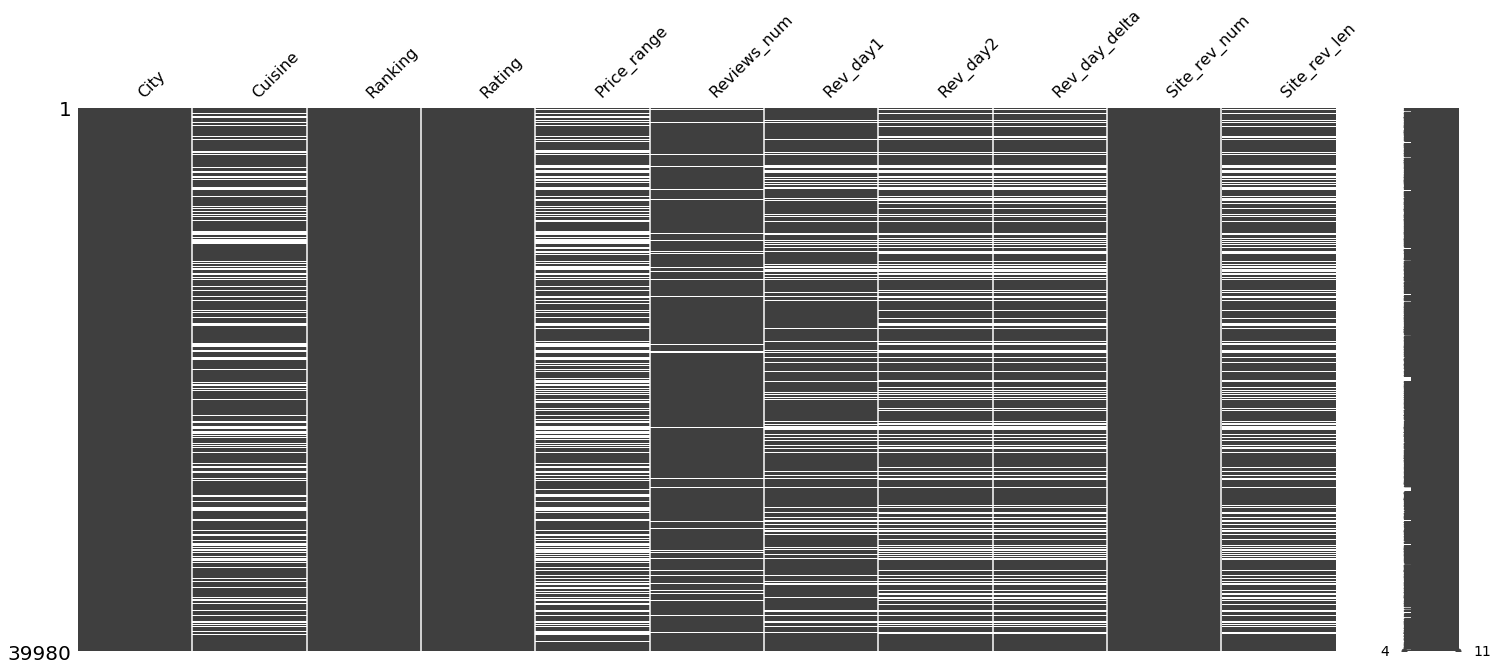

In [383]:
msno.matrix(data);

**Declare categorical features**

In [384]:
categorical_cols = [
    'City',
    'Cuisine',
]

**Просмотр уникальных значений**

Просматриваем количество уникальных значений категориальных переменных

In [385]:
categorical_unique = {}
for column in categorical_cols:
    categorical_unique[column] = pd.Series(Counter(chain.from_iterable(data.loc[data[column].notna(), column].str.split('|')))).sort_values(ascending=False)
    print((column + ':').ljust(16), end='')
    print(str(len(categorical_unique[column])).rjust(6))

City:               31
Cuisine:           125


Просматриваем сами уникальные значения категориальных переменных

In [386]:
pd.set_option('display.max_rows', None)

for column in categorical_cols:
    print(column + ':')
    # print(categorical_unique[column])
    # print(categorical_unique[column].sort_index())
    print()
    
pd.reset_option('display.max_rows')

City:

Cuisine:



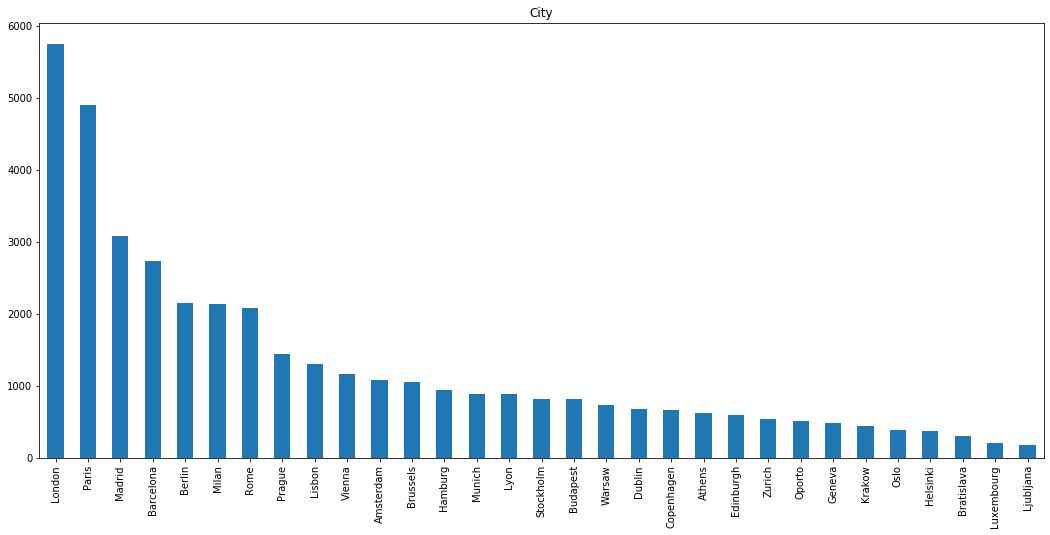

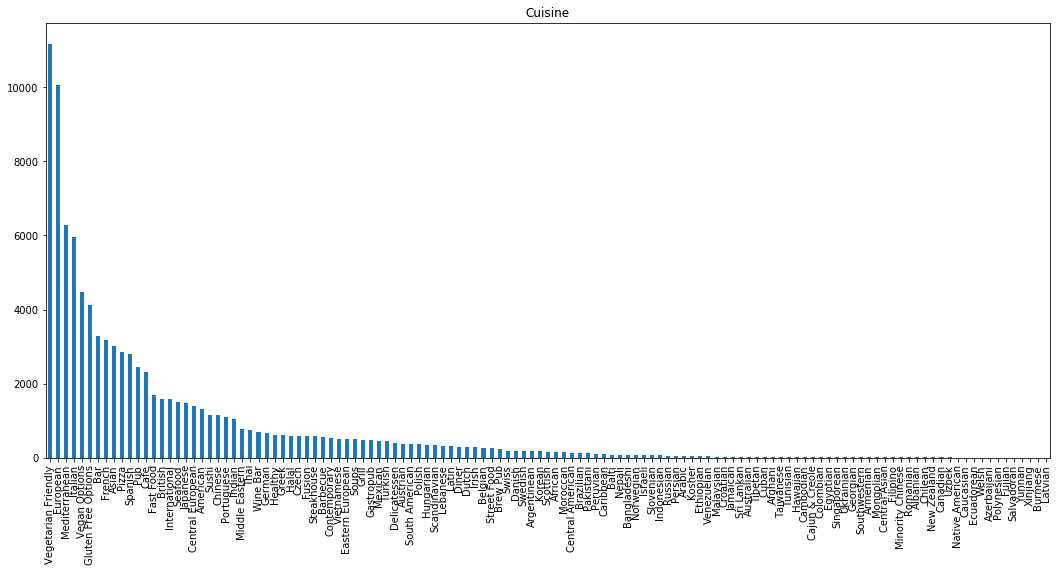

In [387]:
for column in categorical_cols:
    categorical_unique[column].plot.bar(figsize=(18,8), title=column)
    plt.show()
    
# Create figure with [rows] graphs
# rows = len(categorical_cols)
# fig, axs = plt.subplots(rows, figsize=(18, rows*8))

# Plot graphs
# for i, column in enumerate(categorical_cols):
#     axs[i].bar(categorical_unique[column].index, categorical_unique[column].values)
#     axs[i].set_title(column)
#     axs[i].xaxis.set_tick_params(rotation=90)

Просматриваем количество уникальных значений числовых и ординальных переменных

In [388]:
for column in data.columns:
    if data[column].dtype != 'O':
        print(column.join(['', ':']).ljust(16), end='')
        print(str(data[column].nunique()).rjust(6))

Ranking:         11934
Rating:              9
Price_range:         3
Reviews_num:      1459
Rev_day1:         2162
Rev_day2:         1498
Rev_day_delta:    1228
Site_rev_num:        3
Site_rev_len:       20


Просматриваем уникальные значения числовых и ординальных переменных (в данном случае уникальных значений для них не много)

In [389]:
columns = ['Rating', 'Price_range', 'Site_rev_num', 'Site_rev_len']

for column in data.columns:
    if data[column].dtype != 'O' and column in columns:
        print(column.join(['', ':']).ljust(16), end='')
        print(np.sort(data[column].unique()))

Rating:         [1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
Price_range:    [1.  2.5 4.  nan]
Site_rev_num:   [0 1 2]
Site_rev_len:   [ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10.   nan]


**Declare target variable, quantity and ordinal features**

In [390]:
# Declare target variable
target = ['Rating']

# Declare quantity features
quantity_cols = [
    'Ranking',
    'Price_range',
    'Reviews_num',
    'Rev_day1',
    'Rev_day2',
    'Rev_day_delta',
    'Site_rev_num',
    'Site_rev_len',
]

# Declare ordinal features
ordinal_cols = [
]

### Dirty data (wrong values) handling
Проводим замену неверных значений на NaN для переменных с ограниченным набором возможных значений

In [391]:
# Fill the dict with possible column values
possible_vals = {}

In [392]:
for column, vals in possible_vals.items():
    # Add NaN to list
    vals = list(vals)
    vals.append(np.nan)
    
    # Replace values
    mask = data[column].isin(vals)
    data[column].where(mask, inplace=True)
    
    # Show the result
    replaced_num = data[column].shape[0] - mask.sum()
    if replaced_num:
        print(f"{str(replaced_num).rjust(6)} cells have been replaced with NaN in column '{column}'")

### Outliers handling
**Просмотр боксплотов и удаление выбросов**

Строим боксплоты числовых переменных и проверяем их на наличие выбросов

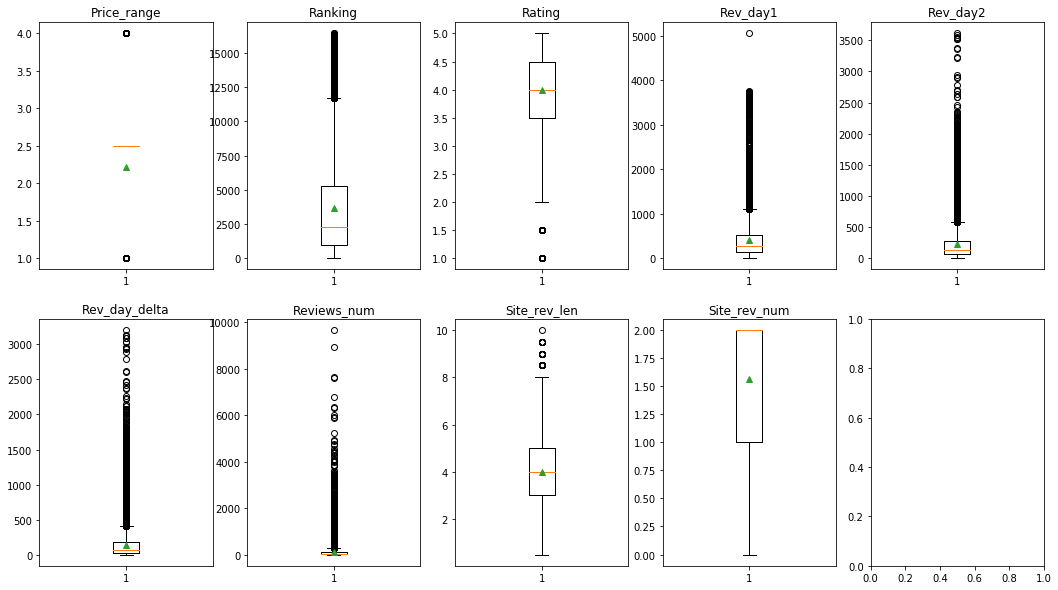

In [393]:
# Union quantity columns with target variable
columns = sorted(quantity_cols + target)

# Create figure with [rows x cols] graphs
cols = 5
rows = math.ceil((len(columns)) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(18, rows*5))

# Plot graphs
for i, column in enumerate(columns):
    if rows == 1:
        idx = i%cols
    else:
        idx = (i//cols, i%cols)
    axs[idx].boxplot(data.loc[data[column].notna(), column], showmeans=True)
    axs[idx].set_title(column)

Просматриваем количество выбросов

In [394]:
idx_dict = {}
for column in columns:
    # Calculate NaNs, Q1, Q3, IQR
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate indices of rows
    idx_dict[column] = list(data.loc[(~data[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR)) & (data[column].notna()), column].index)

    # Show the result
    outliers_num = len(idx_dict[column])
    if outliers_num:
        print(f"{str(outliers_num).rjust(6)} outliers are in column '{column}'")

  7699 outliers are in column 'Price_range'
  2447 outliers are in column 'Ranking'
   340 outliers are in column 'Rating'
  2360 outliers are in column 'Rev_day1'
  2559 outliers are in column 'Rev_day2'
  2290 outliers are in column 'Rev_day_delta'
  4345 outliers are in column 'Reviews_num'
   106 outliers are in column 'Site_rev_len'


Удаляем строки с выбросами

In [395]:
# Remove some columns from the process
cols = ['Price_range', 'Rev_day1']
for col in cols:
    columns.remove(col)

# Union indices
idx = set()
for column in columns:
    idx.update(idx_dict[column])

# Drop rows with outliers
data.drop(idx, inplace=True)
print(f"{len(idx)} rows have been dropped")

10821 rows have been dropped


**Просмотр гистограмм (распределений)**

Просматриваем распределения числовых и ординальных переменных

In [396]:
# Fill the list of bins' step of quantity column and target variable
bin_step = {
    'Price_range': 0.5,
    'Rating': 0.5,
    'Site_rev_num': 1,
    'Site_rev_len': 0.5,
}

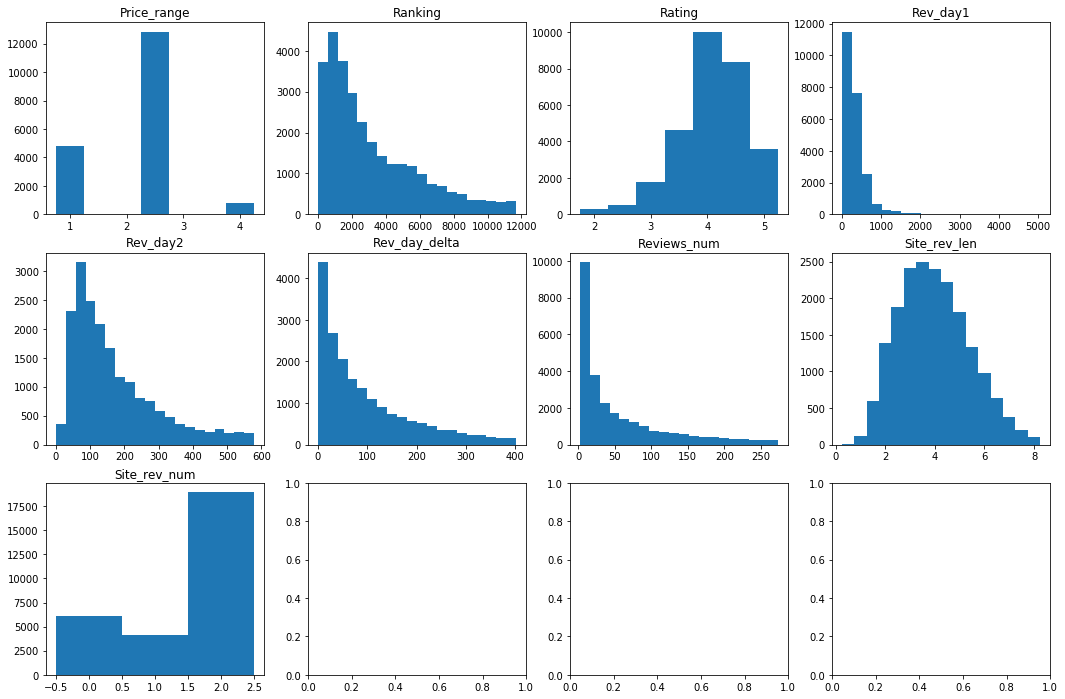

In [397]:
# Union quantity columns, ordinal columns and target variable
columns = sorted(quantity_cols + ordinal_cols + target)

# Create figure with [rows x cols] graphs
cols = 4
rows = math.ceil(len(columns)/cols)
fig, axs = plt.subplots(rows, cols, figsize=(18, rows*4))

# Plot graphs
for i, column in enumerate(columns):
    # Calculate indices of subplots
    if rows == 1:
        idx = i%cols
    else:
        idx = (i//cols, i%cols)

    # Calculate number of bins and ranges
    if column in bin_step.keys():
        col_max = data[column].max()
        col_min = data[column].min()
        step = bin_step[column]
        offset = step / 2
        bins = int((col_max-col_min) / step) + 1
        range_ = (col_min - offset, col_max + offset)
    elif column in ordinal_cols:
        col_max = data[column].max()
        col_min = data[column].min()
        bins = int((col_max-col_min) * 2) + 1
        range_ = (col_min - 0.25, col_max + 0.25)
    else:
        bins = 20
        range_ = None

    # Plot
    axs[idx].hist(data.loc[data[column].notna(), column], bins, range_)
    axs[idx].set_title(column)

### Correlation analysis
**Рассчет матрицы корреляций**

In [398]:
corr_table = data.corr()
corr_table

,Ranking,Rating,Price_range,Reviews_num,Rev_day1,Rev_day2,Rev_day_delta,Site_rev_num,Site_rev_len
Ranking,1.000000,-0.201658,-0.076831,-0.242216,0.148669,0.132302,0.088682,-0.217580,-0.002381
Rating,-0.201658,1.000000,-0.054717,-0.075762,-0.078913,-0.068668,-0.112283,0.002743,-0.015872
Price_range,-0.076831,-0.054717,1.000000,0.210248,-0.075474,-0.054393,-0.044512,0.047921,0.008278
Reviews_num,-0.242216,-0.075762,0.210248,1.000000,-0.274406,-0.241919,-0.186867,0.400810,-0.002288
Rev_day1,0.148669,-0.078913,-0.075474,-0.274406,1.000000,0.827010,0.668058,-0.439308,0.026014
Rev_day2,0.132302,-0.068668,-0.054393,-0.241919,0.827010,1.000000,0.134161,NaN,0.020272
Rev_day_delta,0.088682,-0.112283,-0.044512,-0.186867,0.668058,0.134161,1.000000,NaN,0.019024
Site_rev_num,-0.217580,0.002743,0.047921,0.400810,-0.439308,NaN,NaN,1.000000,NaN
Site_rev_len,-0.002381,-0.015872,0.008278,-0.002288,0.026014,0.020272,0.019024,NaN,1.000000


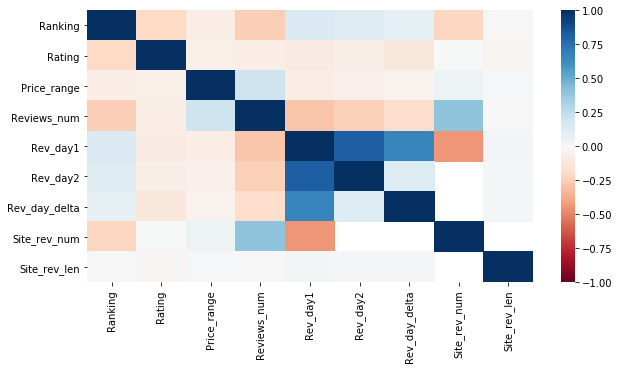

In [399]:
plt.subplots(figsize=(10, 5))
sns.heatmap(corr_table, vmin=-1, vmax=1, cmap="RdBu");

**Удаление пропорциональных признаков**

In [400]:
#cols = []
cols = ['Rev_day1']
data.drop(columns=cols, inplace=True)

# Update quantity and ordinal feature lists
quantity_cols = [col for col in quantity_cols if col not in cols]
ordinal_cols = [col for col in ordinal_cols if col not in cols]

**Удаление признаков без корреляции с целевой переменной**

Сортируем значения корреляций с target по модулю

In [401]:
corr_table[target[0]].abs().sort_values(ascending=False)

Rating           1.000000
Ranking          0.201658
Rev_day_delta    0.112283
Rev_day1         0.078913
Reviews_num      0.075762
Rev_day2         0.068668
Price_range      0.054717
Site_rev_len     0.015872
Site_rev_num     0.002743
Name: Rating, dtype: float64

In [402]:
cols = []
#cols = ['Site_rev_len', 'Site_rev_num']
data.drop(columns=cols, inplace=True)

# Update quantity and ordinal feature lists
quantity_cols = [col for col in quantity_cols if col not in cols]
ordinal_cols = [col for col in ordinal_cols if col not in cols]

### Significance analysis of categorical features
**Hypothesis testing**

С помощью теста Стьюдента проверим есть ли статистически значимая разница в распределении целевой переменной для разных значений категориальных признаков. Проверяем нулевую гипотезу о том, что распределения целевой переменной по различным значениям категориальных переменных неразличимы.

In [403]:
NUM_OF_VALS = 10

# Find not significant features
mask = {}
top_values = {}
not_signif_columns = []
for column in categorical_cols:
    # Find top NUM_OF_VALS values
    top_values[column] = categorical_unique[column].index[:NUM_OF_VALS]
    
    # Find boolean masks
    mask[column] = {}
    for value in top_values[column]:
        mask[column][value] = (data[column].str.contains('(?:^|\|)'+value+'(?:$|\|)')) & (data[target[0]].notna())

    # Student t-test for value combinations
    combs = list(combinations(top_values[column], 2))
    for comb in combs:
        if ttest_ind(data.loc[mask[column][comb[0]], target[0]], 
                     data.loc[mask[column][comb[1]], target[0]]) \
                        .pvalue <= 0.05/len(combs): # Bonferroni correction
            break
    else:
        not_signif_columns.append(column)

# Show result
print('Statistically significant differences have NOT been found for columns:')
for column in not_signif_columns:
    print(f"'{column}'")

Statistically significant differences have NOT been found for columns:


**Удаление признаков без статистически значимых различий**

In [404]:
# cols = []
cols = not_signif_columns
data.drop(columns=cols, inplace=True)

# Update categorical feature list
categorical_cols = [col for col in categorical_cols if col not in cols]

**Построение боксплотов значимых признаков**

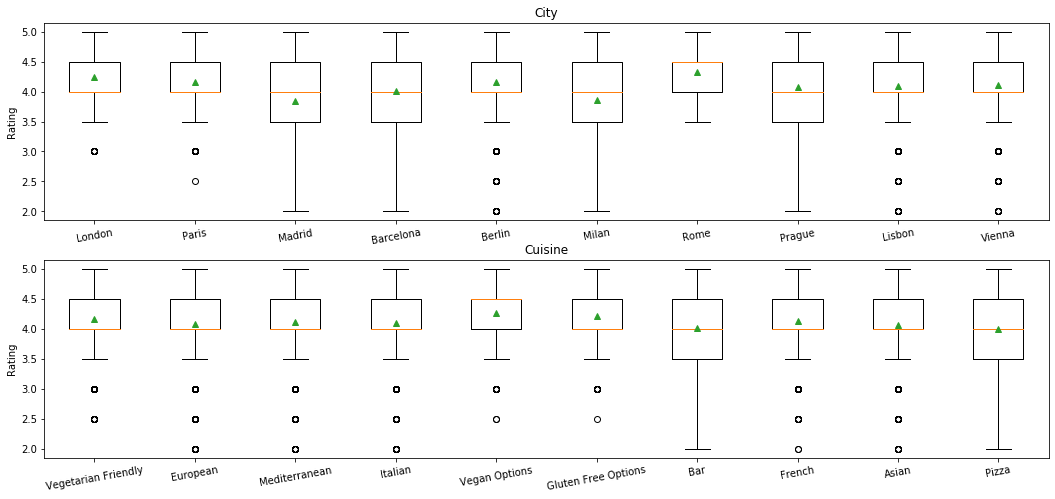

In [405]:
# Create figure with [rows x cols] graphs
rows = len(categorical_cols)
fig, axs = plt.subplots(rows, figsize=(18, rows*4))

# Plot graphs
for i, column in enumerate(categorical_cols):
    axs[i].boxplot([data.loc[mask[column][value], target[0]] for value in top_values[column]], showmeans=True)
    axs[i].set_title(column)
    axs[i].set_xticklabels(top_values[column], rotation=10)
    axs[i].set_ylabel(target[0])

### Missing values handling

Drop rows with missing values of target variable

In [406]:
data.dropna(subset=[target[0]], inplace=True)

Fill missing values of quantity and ordinal features

In [407]:
# Use a function to calc values to replace NaNs
func = ['mean'] # Use list-like value to speed up calc

# Calculate values
replace_vals = data.agg(func)

# Fill the dict of columns' values to replace NaN
# replace_vals = {
#     'Ranking': data['Ranking'].mean(),
#     'Price_range': data['Price_range'].mean(),
#     'Reviews_num': data['Reviews_num'].mean(),
#     'Rev_day1': data['Rev_day1'].mean(),
#     'Rev_day2': data['Rev_day2'].mean(),
#     'Rev_day_delta': data['Rev_day_delta'].mean(),
#     'Site_rev_num': data['Site_rev_num'].mean(),
#     'Site_rev_len': data['Site_rev_len'].mean(),
# }

for column in quantity_cols + ordinal_cols:
    # Show the result
    print(f"{str(data[column].isna().sum()).rjust(6)} NaN have been replaced in column '{column}'")
    # Replace missing values
    data[column].fillna(replace_vals[column][0], inplace=True)

     0 NaN have been replaced in column 'Ranking'
 10697 NaN have been replaced in column 'Price_range'
  2182 NaN have been replaced in column 'Reviews_num'
 10202 NaN have been replaced in column 'Rev_day2'
 10202 NaN have been replaced in column 'Rev_day_delta'
     0 NaN have been replaced in column 'Site_rev_num'
 10204 NaN have been replaced in column 'Site_rev_len'


Fill missing values of categorical features

In [408]:
for column in categorical_cols:
    # Show the result
    print(f"{str(data[column].isna().sum()).rjust(6)} NaN have been replaced in column '{column}'")
    # Replace missing values
    data[column].fillna(categorical_unique[column].index[0], inplace=True)

     0 NaN have been replaced in column 'City'
  7411 NaN have been replaced in column 'Cuisine'


### Dummies generation

In [410]:
# Generate dummies
for column in categorical_cols:
    data = pd.concat([data, data[column].str.get_dummies()], axis=1)
    
# Drop categorical columns
data.drop(categorical_cols, axis=1, inplace=True)

## Обучение модели
### Разбивка данных
Разбиваем датафрейм на части: Х - features, у - target variable

In [411]:
X = data.drop(target[0], axis=1)
y = data[target[0]]

Разбиваем датафрейм на части для обучения и тестирования модели

In [412]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Создание, обучение и тестирование модели

In [413]:
# Create model
regr = RandomForestRegressor(n_estimators=100)

# Learn model on the train set
regr.fit(X_train, y_train)

# Predict target variable on the test set
y_pred = regr.predict(X_test)

In [414]:
# Calculate metric: Mean Absolute Error (MAE)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21269615912208503
